In [1]:
# math and ml libraries
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
from google.colab.patches import cv2_imshow


# neural imaging
!pip install nilearn
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 22.0 MB/s eta 0:00:00


In [2]:
# allow google colab to access user google drive
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [3]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

In [4]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [5]:
IMG_SIZE=128

In [6]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

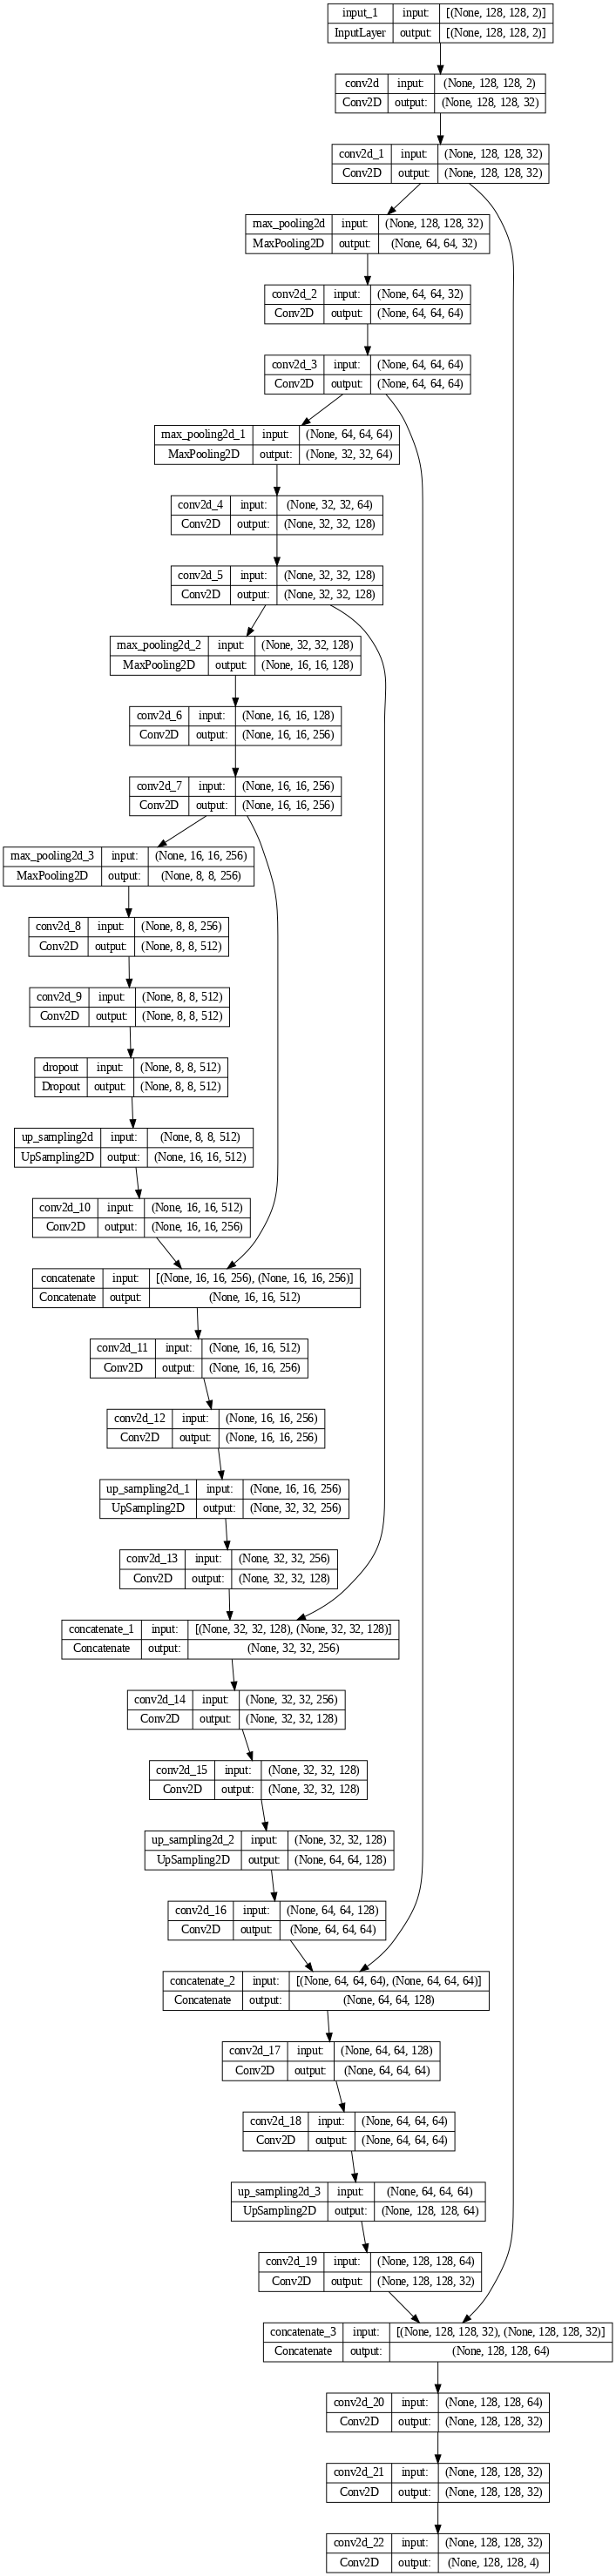

In [7]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [8]:
K.clear_session()

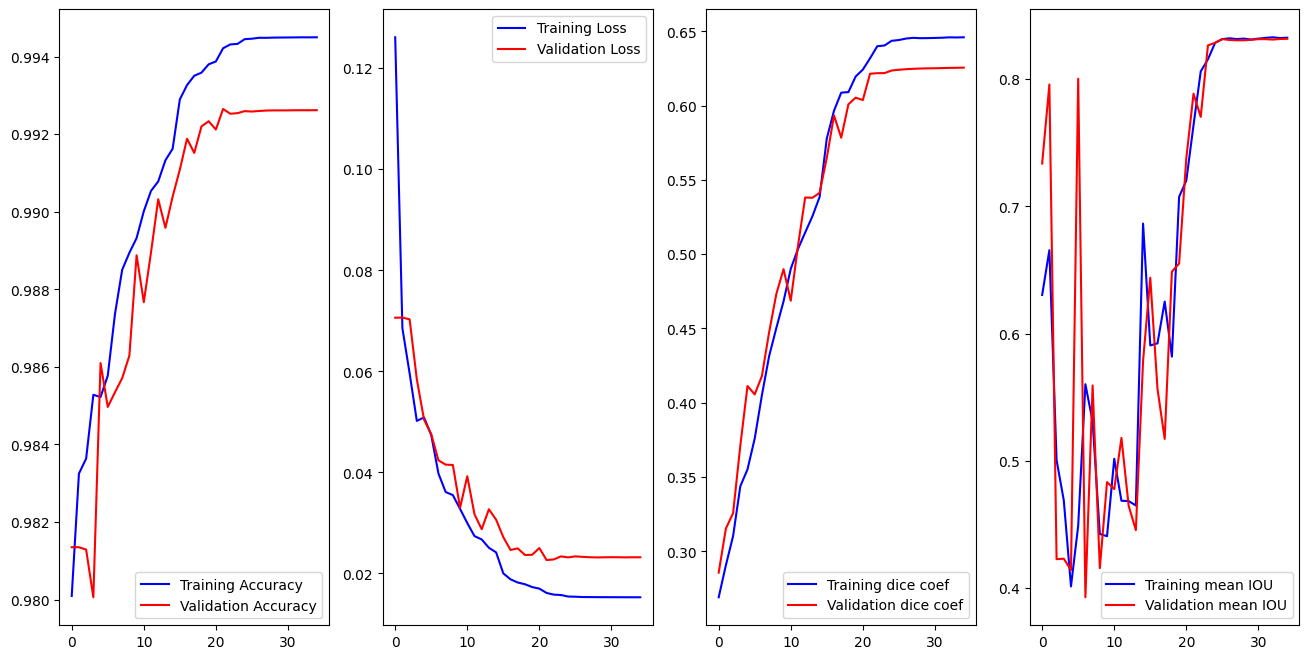

In [9]:
############ load trained model ################
model = keras.models.load_model('/content/gdrive/MyDrive/BrainTumorSegmentation/model_per_class.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/content/gdrive/MyDrive/BrainTumorSegmentation/training_per_class.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [10]:
def predictByPath(img_path,img_id):
    files = next(os.walk(img_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

    vol_path = os.path.join(img_path, f'BraTS20_Validation_{img_id}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    # vol_path = os.path.join(img_path, f'BraTS20_Validation_{img_id}_t1ce.nii');
    # ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        #X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))


    return model.predict(X/np.max(X), verbose=1)

4/4 [==============================] - 10s 286ms/step


<Figure size 640x480 with 0 Axes>

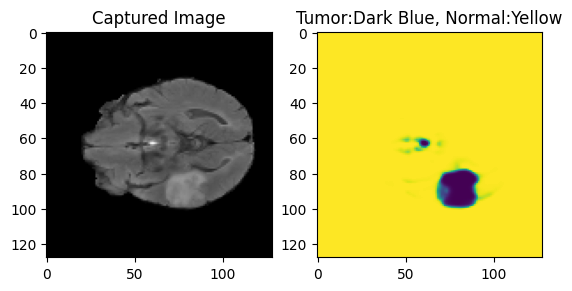

In [11]:
img_id ='107'
path = f"/content/gdrive/MyDrive/BrainTumorSegmentation/Data"
origImage = nib.load(os.path.join(path, f'BraTS20_Validation_{img_id}_flair.nii')).get_fdata()
p = predictByPath(path,img_id)

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 0 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'


#gt[gt != eval_class] = 1 # use only one class for per class evaluation

#resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.resize(origImage[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
axarr[0].title.set_text('Captured Image')
#axarr[1].imshow(resized_gt, cmap="gray")
#axarr[1].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class])
# axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
axarr[1].title.set_text(f'Tumor:Dark Blue, Normal:Yellow')
plt.show()

Text(0.5, 1.0, 'Tumor Highlighted')

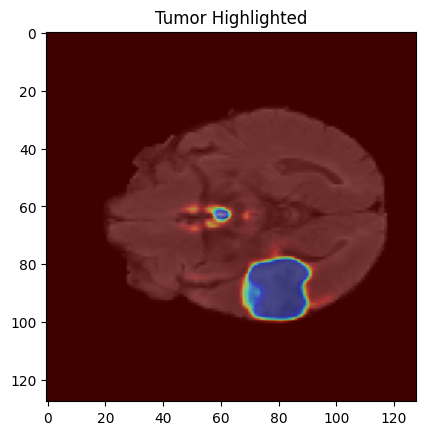

In [12]:
plt.imshow(cv2.resize(origImage[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
plt.imshow(p[i,:,:,eval_class], cmap='jet', alpha=0.5)
plt.title(f'Tumor Highlighted')